In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [2]:
df_stocks = pd.read_pickle('Data/pickled_ten_year_filtered_data.pkl')

In [3]:
import os
cwd = os.getcwd()
print(cwd)

/Users/shankar/dev/projects/personal/ml/data_science/deep-learning-siraj/stock_market_prediction


In [4]:
df_stocks

,close,adj close,articles
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...
2007-01-06,12406.503255,12406.503255,. A Status Quo Secretary General. Best Buy and...
2007-01-07,12414.996745,12414.996745,. THE COMMON APPLICATION; Typo.com. Jumbo Bonu...
2007-01-08,12423.490234,12423.490234,. VW Group’s Sales Rose Sharply in 2006. Conso...
2007-01-09,12416.599609,12416.599609,. The Claim: Hot Leftovers Should Cool at Roo...
2007-01-10,12442.160156,12442.160156,. Love Among the Ruins. Dell Says Plant a Tree...


In [5]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)
df_stocks = df_stocks[['prices', 'articles']]


In [6]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))
df_stocks

/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...
2007-01-06,12406,A Status Quo Secretary General. Best Buy and ...
2007-01-07,12414,THE COMMON APPLICATION; Typo.com. Jumbo Bonus...
2007-01-08,12423,VW Group’s Sales Rose Sharply in 2006. Consol...
2007-01-09,12416,The Claim: Hot Leftovers Should Cool at Room...
2007-01-10,12442,"Love Among the Ruins. Dell Says Plant a Tree,..."


In [7]:
df = df_stocks[['prices']].copy()
df

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398
2007-01-06,12406
2007-01-07,12414
2007-01-08,12423
2007-01-09,12416
2007-01-10,12442


In [8]:
#nltk.download()

In [9]:
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles']).encode('ascii', 'ignore')
        ss = sid.polarity_scores(sentence)
        df.set_value(date, 'compound', ss['compound'])
        df.set_value(date, 'neg', ss['neg'])
        df.set_value(date, 'neu', ss['neu'])
        df.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print df_stocks.loc[date, 'articles']
        print date

In [11]:
df

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9735,0.153,0.748,0.099
2007-01-02,12472,-0.9664,0.122,0.784,0.095
2007-01-03,12474,-0.9994,0.207,0.733,0.06
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082
2007-01-06,12406,-0.965,0.134,0.771,0.094
2007-01-07,12414,-0.9975,0.193,0.739,0.069
2007-01-08,12423,-0.973,0.114,0.788,0.098
2007-01-09,12416,-0.9945,0.104,0.844,0.052
2007-01-10,12442,-0.9863,0.141,0.742,0.117


In [12]:

train_start_date = '2007-01-01'
train_end_date = '2007-12-31'
test_start_date = '2015-01-01'
test_end_date = '2016-12-31'
train = df.loc[train_start_date: train_end_date]
test = df.loc[test_start_date: test_end_date]

In [13]:
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'], df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [14]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'], df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [15]:
y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])

In [16]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
print rf.feature_importances_

[ 0.53417084  0.46582916]


In [18]:
prediction, bias, contributions = ti.predict(rf, numpy_df_test)

In [19]:
prediction

array([ 13100.2       ,  13249.4       ,  13494.6       ,  12958.7       ,
        12967.2       ,  12654.2       ,  13314.6       ,  12620.1       ,
        12831.8       ,  12691.4       ,  12699.5       ,  13313.3       ,
        13190.6       ,  13163.2       ,  13031.4       ,  13200.1       ,
        13155.7       ,  13056.1       ,  13431.        ,  13496.4       ,
        12956.3       ,  13065.5       ,  13258.4       ,  13700.3       ,
        13167.6       ,  13015.2       ,  13695.3       ,  12936.5       ,
        13221.3       ,  13010.3       ,  12562.        ,  12838.3       ,
        13249.9       ,  13113.        ,  12942.6       ,  13529.1       ,
        13066.2       ,  12714.2       ,  13416.1       ,  12848.1       ,
        13351.3       ,  13547.7       ,  13110.        ,  13313.9       ,
        12645.1       ,  12943.4       ,  13308.4       ,  13067.9       ,
        13315.7       ,  13229.7       ,  12655.5       ,  13441.4       ,
        13876.7       ,  

In [20]:
contributions

array([[-166.06939542,   96.41487487],
       [  22.96033679,   56.58514266],
       [ 193.55237973,  131.19309972],
       ..., 
       [-314.28039088,  -32.87412967],
       [-250.90876304,  214.75424249],
       [-181.9960122 ,  672.84149165]])

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
idx = pd.date_range(test_start_date, test_end_date)
predictions_df = pd.DataFrame(data=prediction[0:], index=idx, columns=['prices'])

In [23]:
#predictions_df['predicted'] = predictions_df['prices']
#predictions_df = predictions_df[['predicted']]

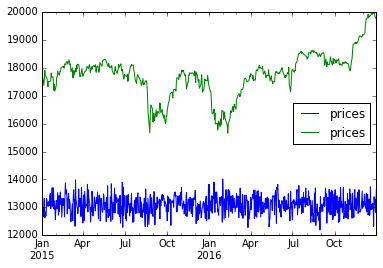

In [24]:
predictions_plot = predictions_df.plot()

fig = y_test.plot(ax = predictions_plot).get_figure()
#fig.savefig("graphs/random_forest_without_smoothing.png")

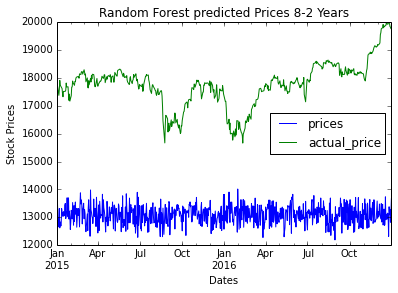

In [25]:
ax = predictions_df.rename(columns={"predicted": "predicted_price"}).plot(title='Random Forest predicted Prices 8-2 Years')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax=ax).get_figure()


In [26]:
test

,prices,compound,neg,neu,pos
2015-01-01,17828,-0.9484,0.142,0.736,0.121
2015-01-02,17832,-0.9775,0.149,0.759,0.093
2015-01-03,17722,-0.9737,0.131,0.787,0.083
2015-01-04,17612,-0.9971,0.22,0.716,0.064
2015-01-05,17501,-0.9905,0.156,0.767,0.077
2015-01-06,17371,-0.9985,0.171,0.752,0.077
2015-01-07,17584,-0.9968,0.152,0.784,0.064
2015-01-08,17907,-0.9993,0.191,0.729,0.08
2015-01-09,17737,-0.9979,0.178,0.733,0.089
2015-01-10,17705,-0.9979,0.198,0.751,0.051


In [28]:
from datetime import datetime, timedelta
temp_date = test_start_date
average_last_5_days_test = 0
total_days = 10
for i in range(total_days):
    average_last_5_days_test += test.loc[temp_date, 'prices']
    # Converting string to date time
    temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
    # Reducing one day from date time
    difference = temp_date + timedelta(days=1)
    # Converting again date time to string
    temp_date = difference.strftime("%Y-%m-%d")
    
average_last_5_days_test = average_last_5_days_test / total_days
print average_last_5_days_test

temp_date = test_start_date
average_upcoming_5_days_predicted = 0

for i in range(total_days):
    average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
    temp_date =datetime.strptime(temp_date, "%Y-%m-%d").date()
    difference = temp_date + timedelta(days=1)
    temp_date = difference.strftime('%Y-%m-%d')
    print temp_date
    
average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
print average_upcoming_5_days_predicted
difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
print difference_test_predicted_prices


    

17679
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
12988.22
4690.78


In [30]:
predictions_df['prices'] = predictions_df['prices'] + difference_test_predicted_prices
predictions_df = predictions_df[['prices']]

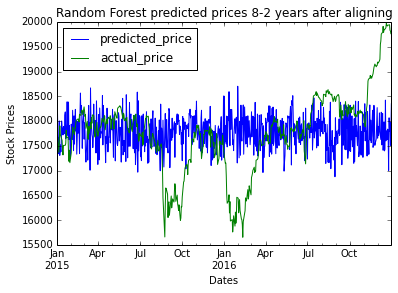

In [31]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices 8-2 years after aligning')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns = {"prices": "actual_price"}).plot(ax=ax).get_figure()


In [32]:
predictions_df['ewma'] = pd.ewma(predictions_df["prices"], span=60, freq="D")

/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True,freq=D).mean()
  """Entry point for launching an IPython kernel.


In [33]:
predictions_df['actual_value'] = test['prices']
predictions_df['actual_value_ewma'] = pd.ewma(predictions_df["actual_value"], span=60, freq="D")
predictions_df

/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True,freq=D).mean()
  


,prices,ewma,actual_value,actual_value_ewma
2015-01-01,17790.980000,17790.980000,17828,17828.000000
2015-01-02,17940.180000,17866.823333,17832,17830.033333
2015-01-03,18185.380000,17976.567742,17722,17792.815295
2015-01-04,17649.480000,17890.662550,17612,17745.326592
2015-01-05,17657.980000,17840.972786,17501,17693.150223
2015-01-06,17344.980000,17751.268115,17371,17634.886512
2015-01-07,18005.380000,17791.299035,17584,17626.870225
2015-01-08,17310.880000,17724.011219,17907,17666.105392
2015-01-09,17522.580000,17698.531889,17737,17675.072954
2015-01-10,17382.180000,17661.944484,17705,17678.534141


In [34]:
predictions_df.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']

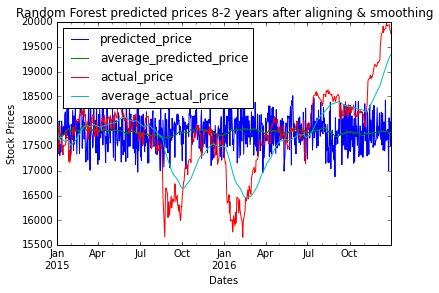

In [35]:
predictions_plot = predictions_df.plot(title='Random Forest predicted prices 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()

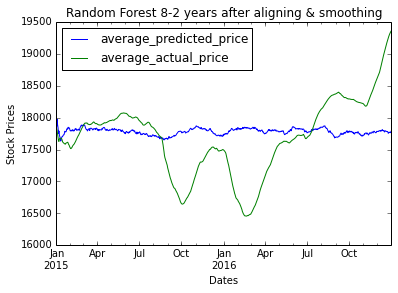

In [36]:
# Plotting just predict and actual average curves
predictions_df_average = predictions_df[['average_predicted_price', 'average_actual_price']]
predictions_plot = predictions_df_average.plot(title='Random Forest 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
#fig.savefig("graphs/random forest after smoothing 2.png")

In [37]:
# Increase the prices by a constant value so that it represents closing price during the testing
def offset_value(test_start_date, test, predictions_df):
    temp_date = test_start_date
    average_last_5_days_test = 0
    average_upcoming_5_days_predicted = 0
    total_days = 10
    for i in range(total_days):
        average_last_5_days_test += test.loc[temp_date, 'prices']
        temp_date =datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_last_5_days_test = average_last_5_days_test / total_days
    
    temp_date = test_start_date
    for i in range(total_days):
        average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
    difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
    return difference_test_predicted_prices        

/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()
/Users/shankar/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:47: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=10,min_periods=0,adjust=True,freq=D).mean()


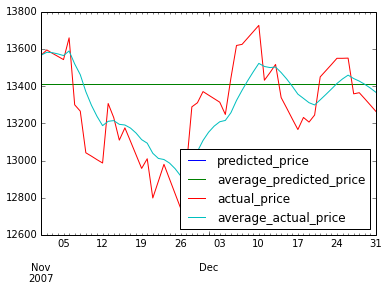

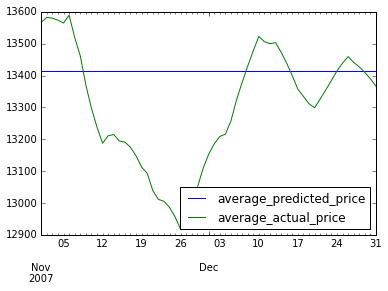

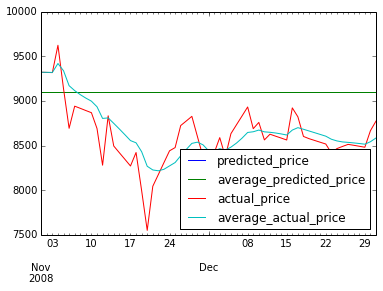

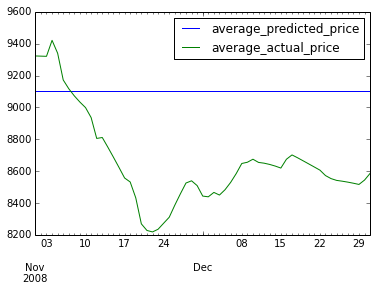

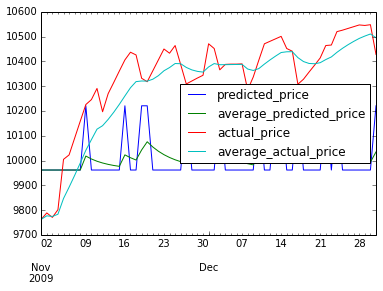

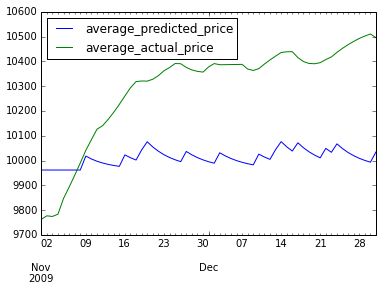

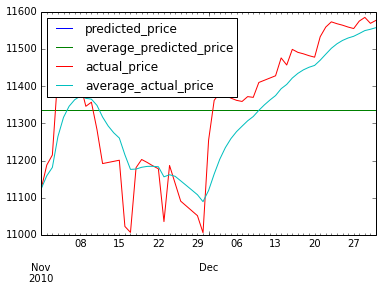

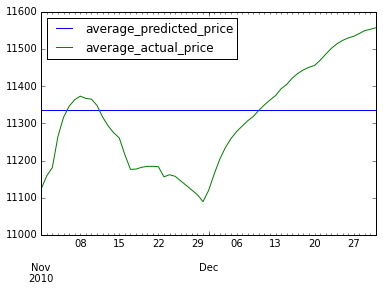

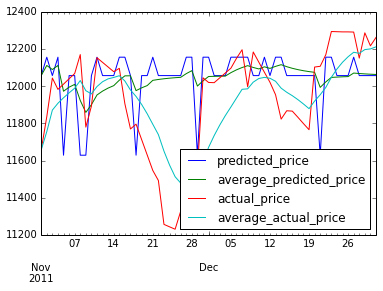

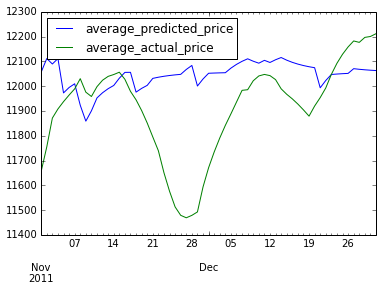

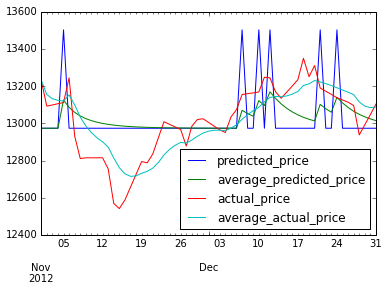

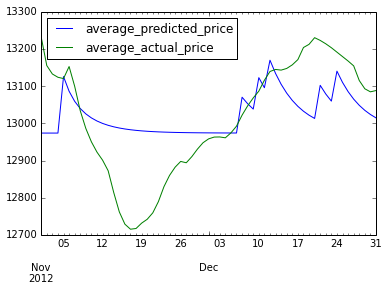

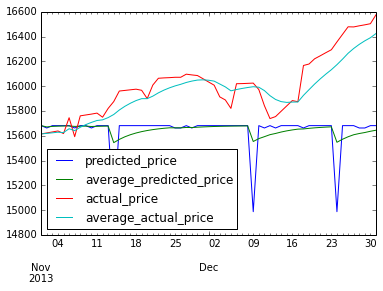

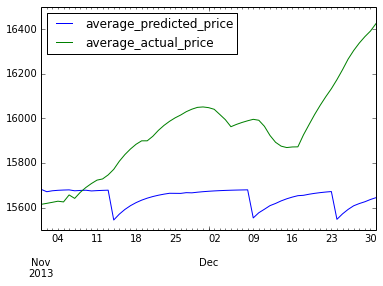

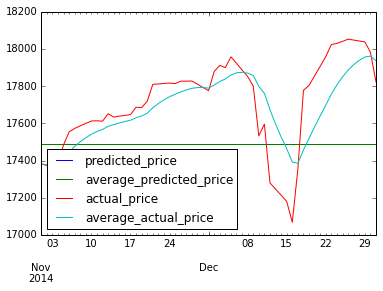

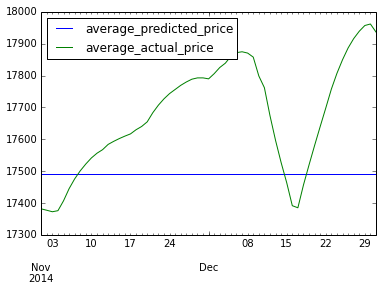

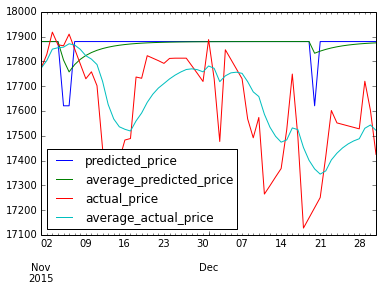

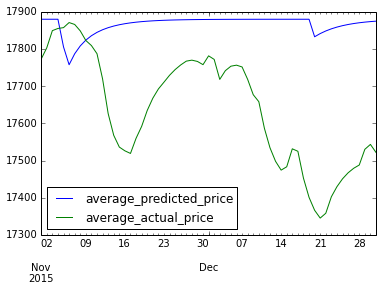

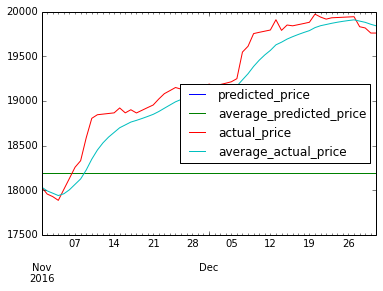

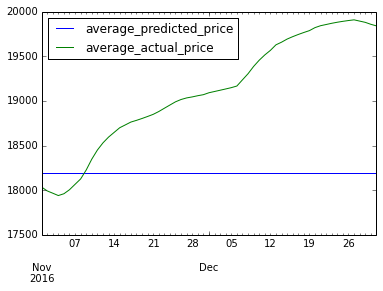

In [44]:
# Logistic Regression
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []

for year in years:
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.loc[train_start_date: train_end_date]
    test = df.loc[test_start_date: test_end_date]
    
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentitment_score = np.asarray([df.loc[date, 'compound'], df.loc[date, 'neg'], df.loc[date, 'neu'], df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'], df.loc[date, 'neg'], df.loc[date, 'neu'], df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)

    # Generating Models
    lr = LogisticRegression()
    lr.fit(numpy_df_train, train['prices'])

    prediction = lr.predict(numpy_df_test)
    prediction_list.append(prediction)

    idx = pd.date_range(test_start_date, test_end_date)
    predictions_df_list = pd.DataFrame(data=prediction[0:], index=idx, columns=['prices'])
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = pd.ewma(predictions_df_list["prices"], span=10, freq="D")
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = pd.ewma(predictions_df_list["actual_value"], span=10, freq="D")

    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    

In [ ]:
test